In [1]:
# import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error

In [2]:
df = pd.read_csv('feature_dataset/nyc_features_final.csv')
df = df.drop(columns = ['Neighborhood'])
print(df.shape)
val = pd.read_csv('feature_dataset/boston_features_final.csv')
val = val.drop(columns = ['Neighborhood'])
print(val.shape)

(24, 15)
(10, 15)


In [3]:
#Normalizeation
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

numerical_columns = val.select_dtypes(include=['float64', 'int64']).columns
val[numerical_columns] = scaler.fit_transform(val[numerical_columns])

In [4]:
X = df.drop(columns = ['SentimentScore'])
y = df['SentimentScore']
y = np.array(y)
X_val = val.drop(columns = ['SentimentScore'])
y_ref = val['SentimentScore']
y_val = val['SentimentScore'].rank(ascending=False, method='min')

In [5]:
X.head()

,WalkScore,BikeScore,TransitScore,Poverty rate,Total Population,Median Age,60 and over,Car-free commute,Median Income,Asian alone,Black/African-American,Hispanic,White alone,Commute time to work
0,0.910112,0.675,0.500000,0.870968,0.264546,0.031008,0.250000,0.795455,0.080455,0.085714,0.051282,0.411765,0.629630,0.504630
1,0.955056,0.850,1.000000,0.580645,0.069143,0.279070,0.250000,0.909091,0.350569,0.085714,0.538462,0.191176,0.358025,0.523148
2,0.876404,0.600,0.900000,0.935484,0.112202,0.077519,0.166667,0.704545,0.000000,0.000000,0.961538,0.191176,0.000000,0.939815
3,0.898876,0.725,0.933333,1.000000,0.109712,0.000000,0.000000,0.727273,0.003791,0.057143,0.294872,0.911765,0.012346,0.712963
4,0.955056,0.925,0.933333,0.225806,0.000000,0.403101,0.166667,0.909091,0.578559,0.114286,0.141026,0.264706,0.666667,0.625000


In [6]:
# for evaluation
def rank(arr):
    sorted_indices = sorted(range(len(arr)), key=lambda x: arr[x])  
    ranks = [0] * len(arr)
    for rank, index in enumerate(sorted_indices, start=1):
        ranks[index] = rank
    return ranks

def evaluate(arr,verbose=True):
    accurate = 0
    for i in range(len(y_val)):
        if(arr[i]==y_val[i]):
            accurate += 1
            if(verbose):
                print(arr[i])
    return accurate/len(y_val)*100

# Linear Regression

In [7]:
# Leave-One-Out Cross-Validation 
loo = LeaveOneOut()

# define model
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# list to calculate RSME
errors = []
weights = []  
intercepts = []  

# loop to do the leave one out
for train_index, test_index in loo.split(X):
    # split the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # learn the model
    model.fit(X_train, y_train)
    
    weights.append(model.coef_[0])  
    intercepts.append(model.intercept_)
    
    # predict
    y_pred = model.predict(X_test)
    
    # add the error to the list
    error = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE
    errors.append(error)

# caculate the average
mean_rmse = np.mean(errors)

print(f"Individual RMSEs: {errors}")
print(f"Mean RMSE: {mean_rmse}")
print(f"Weights (Coefficients): {weights}")
print(f"Intercepts: {intercepts}")

Individual RMSEs: [0.6606099248408805, 0.156701054980819, 0.0718741985994229, 0.02927451411710913, 0.24110272426128265, 0.07274037899427865, 0.10168653504976977, 0.09262013855586693, 0.22009348359535696, 0.4052951798653668, 0.47302758948432866, 0.03172217381309406, 0.7644009835107306, 0.09797545437850452, 0.13369239871659788, 0.32012401651245603, 0.3345531738079143, 0.7534104956081705, 0.06596326990205681, 0.36352728953829005, 1.0916980026287102, 1.022774657001186, 1.0818003017024165, 0.2454591867920054]
Mean RMSE: 0.368005296927359
Weights (Coefficients): [0.38295166514097023, -0.04164676623684981, 0.08083878174900319, 0.022950280057773997, -0.050930522640731085, 0.0005870657381112682, -0.009641397624705533, -0.021686117848587722, 0.01744524408089043, -0.33603319425971295, -0.18239080724617057, 0.009523261527709857, 0.9370697263173036, 0.0001748233673938082, 0.08609311346135597, 0.05770238458647975, -0.12417149920465458, -0.18108587847257934, 0.03949546009305505, 0.10373213517814234, 

In [8]:
# Evaluation 
y_pred_l = model.predict(X_val)
print(evaluate(rank(y_pred_l)))

0.0


## Result
1. no need to do grid search

# Lasso

In [9]:
# Leave-One-Out Cross-Validation 
loo = LeaveOneOut()

# define model
from sklearn.linear_model import Lasso
model = Lasso(alpha=1e-3)

## set the grid search
#param_grid = {'alpha': np.logspace(-2, 1, 10)}  # alphaの値を0.001から10まで対数スケールで探索
#lasso = Lasso()
#
## use MSE as the evaluation score
#def neg_rmse(y_true, y_pred):
#    return -np.sqrt(mean_squared_error(y_true, y_pred))
#
#scorer = make_scorer(neg_rmse)
#
## execute grid search
#grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=loo, scoring=scorer)
#grid_search.fit(X, y)
#
## show the result
#print("Best Parameters:", grid_search.best_params_)
#print("Best RMSE:", grid_search.best_score_)
#print("All Results:")
#for params, mean_test_score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
#    print(f"alpha: {params['alpha']}, RMSE: {mean_test_score}")


# list to calculate RSME
errors = []
weights = []  
intercepts = []  

# loop to do the leave one out
for train_index, test_index in loo.split(X):
    # split the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # learn the model
    model.fit(X_train, y_train)
    
    weights.append(model.coef_[0])  
    intercepts.append(model.intercept_)
    
    # predict
    y_pred = model.predict(X_test)
    
    # add the error to the list
    error = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE
    errors.append(error)

# caculate the average
mean_rmse = np.mean(errors)

print(f"Individual RMSEs: {errors}")
print(f"Mean RMSE: {mean_rmse}")
print(f"Weights (Coefficients): {weights}")
print(f"Intercepts: {intercepts}")


Individual RMSEs: [0.4690713069364689, 0.1031977832236104, 0.0689116885844353, 0.04704801216088683, 0.000642499462700119, 0.004983490946559144, 0.09406248365985936, 0.11017923132180829, 0.2371855444169355, 0.17800614643804002, 0.48089563899263654, 0.03331561110394632, 0.3344847776487866, 0.0587575991742153, 0.016003827723655384, 0.2008116382229519, 0.20635974308870386, 0.10995342252960094, 0.052603991865440736, 0.04124500825164845, 0.932776212837938, 0.2563520350826819, 0.3043016258483733, 0.07040198421825061]
Mean RMSE: 0.18381463765583894
Weights (Coefficients): [0.27105816494251467, 0.0, 0.054958336909950334, 0.016666190394507823, 0.019652143795123086, 0.022396985425786255, 0.0, 0.0, 0.055180652818993634, -0.0, -0.0, 0.017123904288363793, 0.18393135180591416, 0.022220511492313435, 0.013249817862607878, 0.05947694449432823, 0.07889748869890255, 0.009807082330686842, 0.04191234149394506, 0.02578727873905613, 0.24050476614934077, 0.10777039999379634, -0.0, 0.0]
Intercepts: [0.564815702

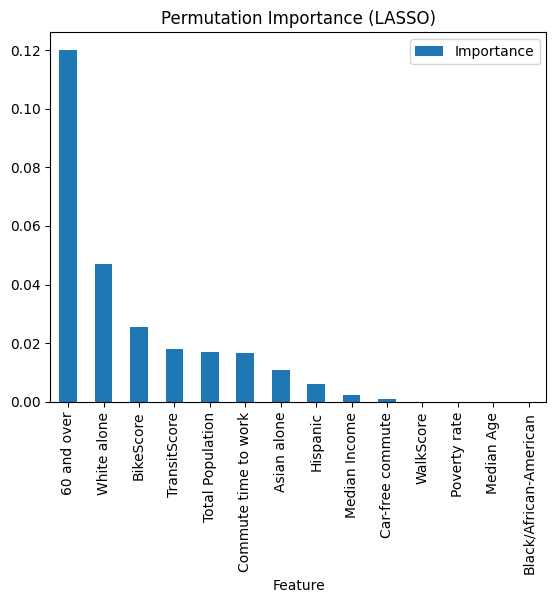

In [10]:
from sklearn.inspection import permutation_importance

lasso_importance = permutation_importance(model, X, y, scoring="neg_root_mean_squared_error")

LASSO_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": lasso_importance.importances_mean
})
LASSO_df.sort_values(by="Importance", ascending=False).plot(x="Feature", y="Importance", kind="bar", title="Permutation Importance (LASSO)")
plt.show()

In [11]:
y_pred_la = model.predict(X_val)
print(evaluate(rank(y_pred_la)))

9
5
20.0


## Result
1. The model will converge lager the alpha = 1e-2, so the range of grid search will be 1e-2~1e10.
2. The best parameter is 46415.888336127726.
3. No doubt that the Lasso is better than the linear regression.

# Random Forests

In [12]:
# Leave-One-Out Cross-Validation 
loo = LeaveOneOut()

# define model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth= None, min_samples_split= 5, n_estimators= 200)


## set grid search
#param_grid = {
#    'n_estimators': [50, 100, 200],  # the number of trees
#    'max_depth': [None, 3, 5],       # the depth
#    'min_samples_split': [2, 5]     # samples needed to split
#}
#
## initialize random forest
#rf = RandomForestRegressor(random_state=42)
#loo = LeaveOneOut()
#
## use RMSE as the evaluation metric
#def neg_rmse(y_true, y_pred):
#    return -np.sqrt(mean_squared_error(y_true, y_pred))
#
#scorer = make_scorer(neg_rmse)
#
## do grid search
#grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=loo, scoring=scorer)
#grid_search.fit(X, y)
#
## show the result
#print("Best Parameters:", grid_search.best_params_)
#print("Best RMSE:", -grid_search.best_score_)  
#print("All Results:")
#for params, mean_test_score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
#    print(f"Params: {params}, RMSE: {-mean_test_score}") # reverse the negative score


# list to calculate RSME
errors = []
feature_importances = [] 
predictions = []  

# loop to do the leave one out
for train_index, test_index in loo.split(X):
    # split the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # learn the model
    model.fit(X_train, y_train)
    
    feature_importances.append(model.feature_importances_[0])
    
    # predict
    y_pred = model.predict(X_test)
    predictions.append(y_pred[0])
    
    # add the error to the list
    error = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE
    errors.append(error)

# caculate the average
mean_rmse = np.mean(errors)

print(f"Individual RMSEs: {errors}")
print(f"Mean RMSE: {mean_rmse}")
print(f"Feature Importances: {feature_importances}")
print(f"Predictions: {predictions}")


Individual RMSEs: [0.05604809528531973, 0.04258944580878965, 0.06756727288978559, 0.036579832035347426, 0.1874844207663786, 0.05516414503177214, 0.014674610693412249, 0.04532924933803528, 0.1017314986582818, 0.05046755776036049, 0.5491581088697985, 0.028709555064684977, 0.05705251838411429, 0.08046567337908284, 0.05062048015667309, 0.01188786628649896, 0.04207349741199096, 0.03827198628911177, 0.007231849799038237, 0.06144498676405985, 0.8538106258267707, 0.12067294888612257, 0.22651826791319452, 0.07773143307677133]
Mean RMSE: 0.11930358026564147
Feature Importances: [0.022783473107947257, 0.020240686213299976, 0.022297285775578796, 0.024315861735265447, 0.016500068762363897, 0.016270350504088052, 0.017275030182678404, 0.022924425311596552, 0.017078968005725795, 0.012544138900530192, 0.0292931700073989, 0.01062408174054628, 0.011994070639285013, 0.01821995113886929, 0.028463599311527695, 0.023559253001671207, 0.019029981130485377, 0.014217881691644067, 0.0239367581431312, 0.0177869557

In [13]:
y_pred_rf = model.predict(X_val)
print(evaluate(rank(y_pred_rf)))

2
10.0


## Result
1. It does not perform well compared to the Decision Tree.
2. May be it is more robust.

# Decision Tree

In [14]:
# Leave-One-Out Cross-Validation 
loo = LeaveOneOut()

# define model
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth = None, min_samples_leaf = 1, min_samples_split =  2)


## set grid research
#param_grid = {
#    'max_depth': [None, 2, 3, 5],        
#    'min_samples_split': [2, 5, 10],   
#    'min_samples_leaf': [1, 2, 4]   
#}
#
## initialize decision tree
#dt = DecisionTreeRegressor(random_state=42)
#loo = LeaveOneOut()
#
## same as above
#def neg_rmse(y_true, y_pred):
#    return -np.sqrt(mean_squared_error(y_true, y_pred))
#
#scorer = make_scorer(neg_rmse)
#
#grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=loo, scoring=scorer)
#grid_search.fit(X, y)
#
#print("Best Parameters:", grid_search.best_params_)
#print("Best RMSE:", -grid_search.best_score_) 
#print("All Results:")
#for params, mean_test_score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
#    print(f"Params: {params}, RMSE: {-mean_test_score}")  


# list to calculate RSME
errors = []
predictions = []  

# loop to do the leave one out
for train_index, test_index in loo.split(X):
    # split the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # learn the model
    model.fit(X_train, y_train)
    
    # predict
    y_pred = model.predict(X_test)
    predictions.append(y_pred[0])
    
    # add the error to the list
    error = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE
    errors.append(error)

# caculate the average
mean_rmse = np.mean(errors)

print(f"Individual RMSEs: {errors}")
print(f"Mean RMSE: {mean_rmse}")
print(f"Predictions: {predictions}")

Individual RMSEs: [0.026702691924653243, 0.00032391973555656595, 0.01760453634192949, 0.01760453634192949, 0.07629445514753552, 0.05915211419051292, 0.00032391973555656595, 0.011504074778389217, 0.03372779094557454, 0.0020263333888392854, 1.0, 0.059516301510808, 0.056252236110355236, 0.0030598942563567766, 0.2648453915702439, 0.00834241863525087, 0.02405981783945821, 0.007505321768663142, 0.010355702020052426, 0.01976724287335596, 1.0, 0.003998753009726075, 0.21948100195666365, 0.09346230920267429]
Mean RMSE: 0.1256629484701702
Predictions: [0.7180964882092381, 0.8072556881914973, 0.7282263777810991, 0.7106218414391696, 0.8069317684559407, 0.7600173298374119, 0.8069317684559407, 0.7381575530389702, 0.8191694440279248, 0.7106218414391696, 0.0, 0.863184004566296, 0.8069317684559407, 0.7351546084297561, 1.0, 0.7282263777810991, 0.7421563060486963, 0.7496616278173595, 0.7496616278173595, 0.7180964882092381, 1.0, 0.7421563060486963, 0.7600173298374119, 0.7180964882092381]


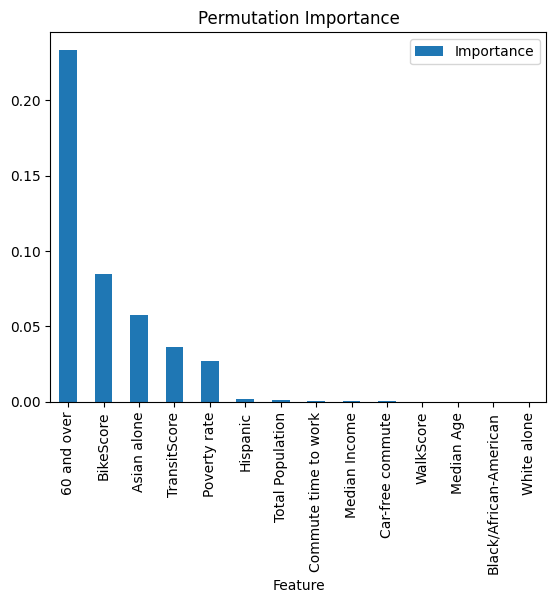

In [15]:
from sklearn.inspection import permutation_importance

model.fit(X, y)


tree_importance = permutation_importance(model, X, y, scoring="neg_root_mean_squared_error")


DT_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": tree_importance.importances_mean,
    "Std Dev": tree_importance.importances_std
})
DT_df.sort_values(by="Importance", ascending=False).plot(x="Feature", y="Importance", kind="bar", title="Permutation Importance")
plt.show()

In [16]:
y_pred_dt = model.predict(X_val)
print(evaluate(rank(y_pred_dt)))

0.0


## Result
1. The result is better than the Lasso.
2. So far, it is SOTA.

# SVM

In [17]:
# Leave-One-Out Cross-Validation 
loo = LeaveOneOut()

# define model
from sklearn.svm import SVR
model = SVR(C = 0.1, epsilon =  0.01, kernel = 'rbf')

## scaling the features
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)
#
## set grid research
#param_grid = {
#    'C': [0.1, 1, 10, 100],         
#    'epsilon': [0.01, 0.1, 0.2],  
#    'kernel': ['linear', 'rbf']     
#}
#
## initial SVR
#svr = SVR()
#loo = LeaveOneOut()
#
#def neg_rmse(y_true, y_pred):
#    return -np.sqrt(mean_squared_error(y_true, y_pred))
#
#scorer = make_scorer(neg_rmse)
#
#grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=loo, scoring=scorer)
#grid_search.fit(X_scaled, y)
#
#
#print("Best Parameters:", grid_search.best_params_)
#print("Best RMSE:", -grid_search.best_score_) 
#print("All Results:")
#for params, mean_test_score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
#    print(f"Params: {params}, RMSE: {-mean_test_score}")  

# list to calculate RSME
errors = []
predictions = []  

# loop to do the leave one out
for train_index, test_index in loo.split(X):
    # split the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # learn the model
    model.fit(X_train, y_train)
    
    # predict
    y_pred = model.predict(X_test)
    predictions.append(y_pred[0])
    
    # add the error to the list
    error = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE
    errors.append(error)

# caculate the average
mean_rmse = np.mean(errors)

print(f"Individual RMSEs: {errors}")
print(f"Mean RMSE: {mean_rmse}")
print(f"Predictions: {predictions}")

Individual RMSEs: [0.059542627363353806, 0.015264090641953998, 0.055438141871278934, 0.014543107985843573, 0.09527217044799341, 0.0451920459716777, 0.05982908749268068, 0.0021502779354912738, 0.113792695848277, 0.05159975544749318, 0.2742337576641607, 0.01678494229239702, 0.08920769348567792, 0.02096121053372979, 0.0028454330117215765, 0.00552310044430282, 0.027978965786441656, 0.031229434591190874, 0.014410591970887343, 0.04192994971227293, 0.7873283109852217, 0.014258987457265393, 0.2507131740028403, 0.11853012123130546]
Mean RMSE: 0.0920233197573108
Predictions: [0.7509364236479387, 0.7916676778139867, 0.7660599833104486, 0.7427694857669427, 0.7879540531554828, 0.7739773980562471, 0.7474266006988166, 0.7475113498818682, 0.7391045391252223, 0.7642479302755021, 0.7257662423358393, 0.7868827607630909, 0.773976311080618, 0.7591757132198427, 0.7380000414414777, 0.7420918968606528, 0.7460754539956798, 0.7733857406398872, 0.7744279218082992, 0.7402591950481551, 0.7873283109852217, 0.752416

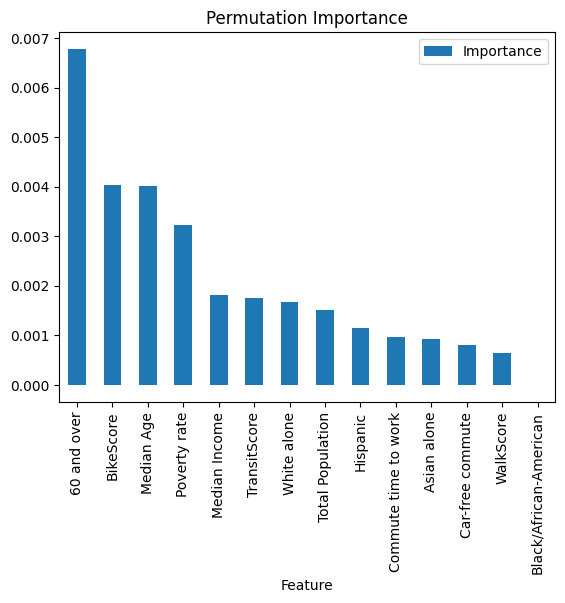

In [18]:
from sklearn.inspection import permutation_importance

# モデルの学習
model.fit(X, y)

# 置換重要度を計算
svm_importance = permutation_importance(model, X, y, scoring="neg_root_mean_squared_error")

# 結果を表示
import pandas as pd
SVM_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": svm_importance.importances_mean,
    "Std Dev": svm_importance.importances_std
})

SVM_df.sort_values(by="Importance", ascending=False).plot(x="Feature", y="Importance", kind="bar", title="Permutation Importance")
plt.show()

In [19]:
y_pred_svm = model.predict(X_val)
print(evaluate(rank(y_pred_svm)))

0.0


## Result
1. It needs to explore more.

# Analysis

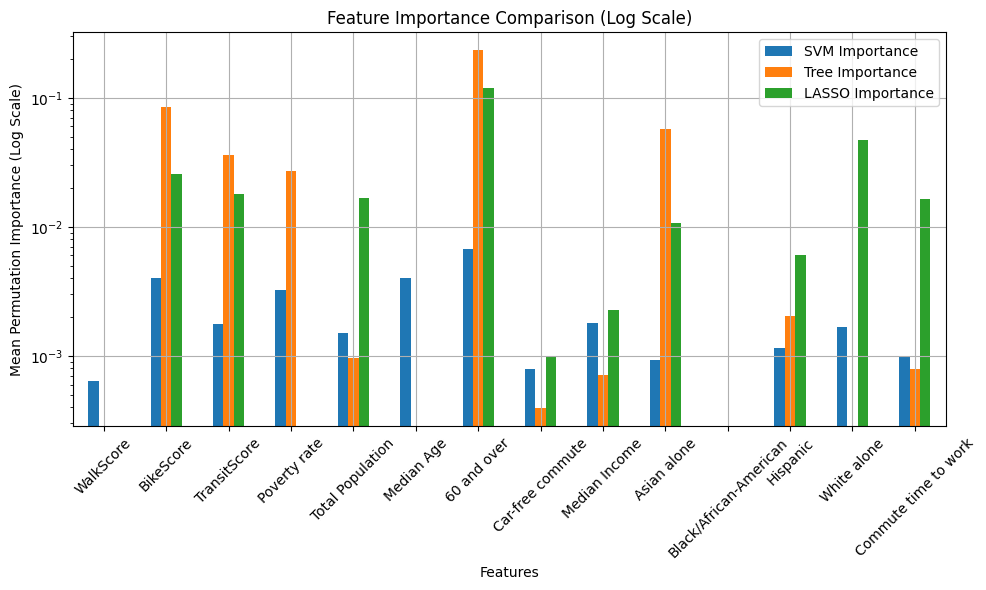

,Feature,SVM Importance,Tree Importance,LASSO Importance
0,WalkScore,0.000635,0.000000,0.000000
1,BikeScore,0.004027,0.084941,0.025570
2,TransitScore,0.001752,0.036102,0.018080
3,Poverty rate,0.003219,0.027268,0.000000
4,Total Population,0.001518,0.000967,0.016860
5,Median Age,0.004010,0.000000,0.000000
6,60 and over,0.006779,0.233549,0.120031
7,Car-free commute,0.000798,0.000392,0.000976
8,Median Income,0.001815,0.000714,0.002262
9,Asian alone,0.000923,0.057811,0.010708


In [20]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'SVM Importance': svm_importance.importances_mean,
    'Tree Importance': tree_importance.importances_mean,
    'LASSO Importance': lasso_importance.importances_mean
})


ax = importance_df.set_index('Feature').plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importance Comparison (Log Scale)')
plt.ylabel('Mean Permutation Importance (Log Scale)')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.yscale('log') 
plt.tight_layout()
plt.grid()
plt.savefig('result')
plt.show()

from IPython.display import display
display(importance_df)

In [21]:
print(y_pred_l)
print(y_pred_la)
print(y_pred_rf)
print(y_pred_dt)
print(y_pred_svm)

[1.63512238 0.74986426 1.44634538 1.33320421 1.0646974  1.23753552
 0.46237469 0.77236308 1.45921015 0.20766095]
[1.14282264 0.83913911 0.66438946 0.40604717 0.68925799 0.60237224
 0.66554744 0.54041169 0.48955808 0.48345553]
[0.82184321 0.77528582 0.75467597 0.83082412 0.79969063 0.73518208
 0.73564074 0.73080076 0.71951724 0.37814604]
[0.863184   0.73815755 0.71264817 0.97949833 0.88322622 0.85289723
 0.8036677  0.62463418 0.69832925 0.        ]
[0.79466677 0.70532991 0.70784363 0.71193484 0.76388583 0.79499632
 0.77564995 0.68355096 0.70763534 0.70903622]


In [22]:
#test = (y_pred_l + y_pred_la + y_pred_rf + y_pred_dt + y_pred_svm)/5
test = (y_pred_la + y_pred_rf )/2
print(evaluate(rank(test)))

9
7
5
2
40.0


In [23]:
import random

def comb():
    combination = random.sample(range(10), 10)
    return combination

In [24]:
Sum = 0
for i in range(100000):
    Sum += evaluate(comb(),verbose=False)
print(Sum/100000)

8.989


In [25]:
c = [0,1,2,3,4,5,6,7,8,9]
print(evaluate(c))

4
5
20.0


/var/folders/hc/wjygws950mb_fqz0jgk13d7h0000gn/T/ipykernel_30870/2253922850.py:36: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax1.legend(bars, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)


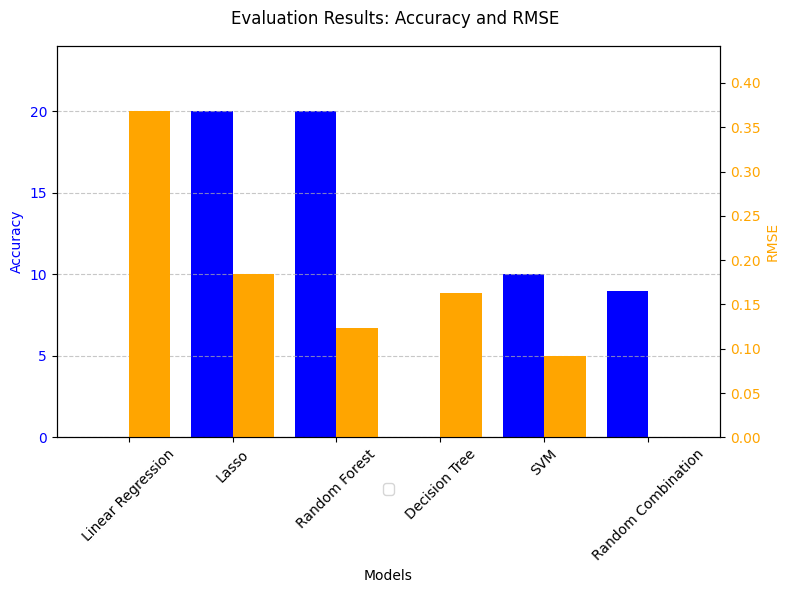

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# データ
categories = ['Linear Regression', 'Lasso', 'Random Forest', 'Decision Tree', 'SVM', 'Random Combination']
values1 = [0, 20, 20, 0, 10, 9]  # Accuracy
values2 = [0.368005296927359, 0.18381463765583894, 0.12365282856591409, 0.1625008670854113, 0.0920233197573108, 0]  # RMSE

x = np.arange(len(categories))


fig, ax1 = plt.subplots(figsize=(8, 6))

# Accuracy 
bar1 = ax1.bar(x - 0.2, values1, width=0.4, label='Accuracy', color='blue')
ax1.set_xlabel("Models")
ax1.set_ylabel("Accuracy", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, max(values1) * 1.2)
ax1.set_xticks(x)
ax1.set_xticklabels(categories, rotation=45)

# RMSE 
ax2 = ax1.twinx()
bar2 = ax2.bar(x + 0.2, values2, width=0.4, label='RMSE', color='orange')
ax2.set_ylabel("RMSE", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim(0, max(values2) * 1.2)

# grid
ax1.grid(axis='y', linestyle='--', alpha=0.7)


bars = bar1 + bar2  
labels = [b.get_label() for b in bars]  # label
ax1.legend(bars, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# title
fig.suptitle("Evaluation Results: Accuracy and RMSE")
fig.tight_layout()

plt.savefig('Evaluation_Result.png', bbox_inches='tight')
plt.show()

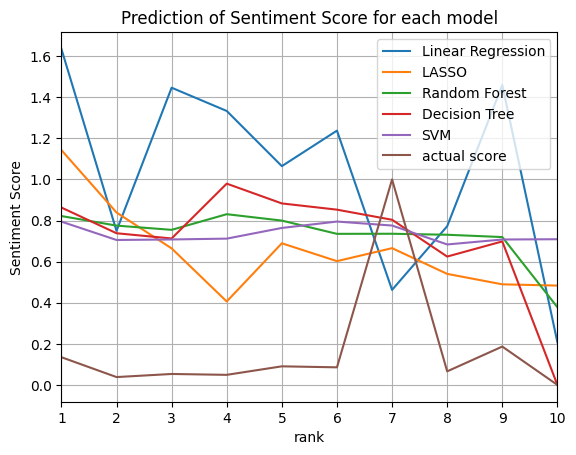

In [27]:
plt.title('Prediction of Sentiment Score for each model')
plt.xlabel('rank')
plt.ylabel('Sentiment Score')
plt.plot(y_pred_l, label = 'Linear Regression')
plt.plot(y_pred_la, label = 'LASSO')
plt.plot(y_pred_rf, label = 'Random Forest')
plt.plot(y_pred_dt, label = 'Decision Tree')
plt.plot(y_pred_svm, label = 'SVM')
plt.plot(y_ref,label = 'actual score')

plt.xticks(range(10), range(1, 11))
plt.legend()
plt.xlim(0,9)
plt.grid()
plt.savefig('summary')
plt.show()


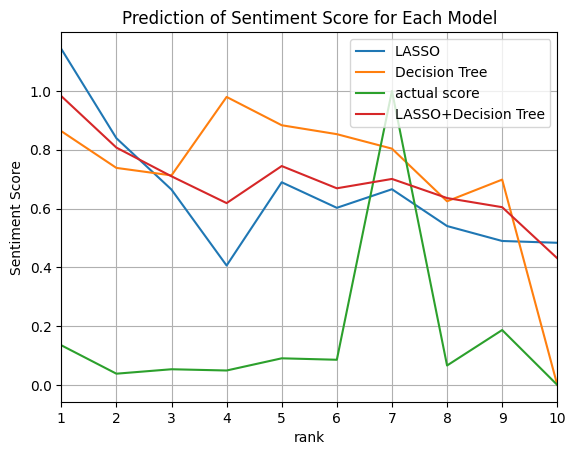

In [28]:
plt.title('Prediction of Sentiment Score for Each Model')
plt.xlabel('rank')
plt.ylabel('Sentiment Score')
plt.plot(y_pred_la, label = 'LASSO')
plt.plot(y_pred_dt, label = 'Decision Tree')
plt.plot(y_ref,label = 'actual score')
plt.plot((y_pred_la + y_pred_rf )/2, label = 'LASSO+Decision Tree')

plt.xticks(range(10), range(1, 11))
plt.legend()
plt.xlim(0,9)
plt.grid()
plt.savefig('discussion')
plt.show()